# 上海交通大学BI908《生物医学图像处理》 Lab 1 @
### SJTU BI908《biomedical image processing》 homework1@your name
-----


## 学生信息（Student information）：
`姓名（Name）：`

`学号 （ID）：`

-----

## 作业内容（Contents）：

### 1 频域内的两个平滑和锐化滤波器

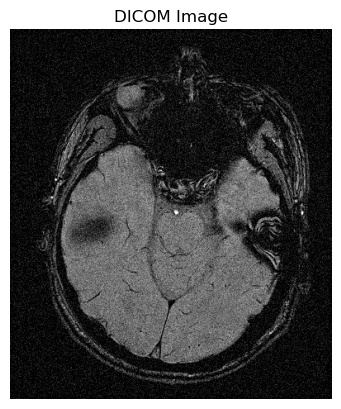

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom

def display(original, changed): 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap=plt.cm.gray)
    axes[0].set_title('Filter')
    axes[0].axis('off')
    axes[1].imshow(changed, cmap=plt.cm.gray)
    axes[1].set_title('Change')
    axes[1].axis('off') 
    plt.tight_layout()


ds = pydicom.dcmread('00000045.dcm')

# 获取图像数据
image_data = ds.pixel_array
shape = (ds.Rows, ds.Columns)

# 添加高斯噪声
mean = 0  # 噪声的均值
std_dev = 20  # 噪声的标准差
gaussian_noise = np.random.normal(mean, std_dev, image_data.shape).astype(np.float32)

# 将噪声添加到图像数据中
noisy_image = image_data + gaussian_noise
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

# 显示图像
plt.imshow(noisy_image, cmap='gray') 
plt.title("DICOM Image")
plt.axis('off') 
plt.show()

四个频域滤波器的截止频率都设定为最大频率的$\frac{1}{4}$

In [2]:
# 首先对原图进行FFT，得到频域图像
fft_img = np.fft.fft2(noisy_image)
fft_img = np.fft.fftshift(fft_img)
fft_img_ori = np.fft.fft2(image_data)
fft_img_ori = np.fft.fftshift(fft_img_ori)
# plt.imshow(np.abs(fft_img), cmap='gray')

In [3]:
# 频域高斯低通滤波器
def gaussian_lowpass_filter(shape, cutoff_frequency):
    
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2

    # 生成网格
    y, x = np.ogrid[:rows, :cols]

    # 计算距离中心的距离
    distance = np.sqrt((x - center_col) ** 2 + (y - center_row) ** 2)

    # 生成高斯滤波器
    filter = np.exp(-(distance ** 2) / (2 * cutoff_frequency ** 2))
    return filter

In [4]:
# 频域理想低通滤波器
def ideal_lowpass_filter(shape, cutoff_frequency):
        
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2

    # 生成网格
    y, x = np.ogrid[:rows, :cols]

    # 计算距离中心的距离
    distance = np.sqrt((x - center_col) ** 2 + (y - center_row) ** 2)

    # 生成高斯滤波器
    filter = np.zeros(shape)
    filter[distance <= cutoff_frequency] = 1
    return filter

In [5]:
# 频域理想高通滤波器
def ideal_highpass_filter(shape, cutoff_frequency):
        
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2

    # 生成网格
    y, x = np.ogrid[:rows, :cols]

    # 计算距离中心的距离
    distance = np.sqrt((x - center_col) ** 2 + (y - center_row) ** 2)

    # 生成高斯滤波器
    filter = np.ones(shape)
    filter[distance <= cutoff_frequency] = 0
    return filter

In [6]:
# 频域高斯高通滤波器
def gaussian_highpass_filter(shape, cutoff_frequency):
    
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2

    # 生成网格
    y, x = np.ogrid[:rows, :cols]

    # 计算距离中心的距离
    distance = np.sqrt((x - center_col) ** 2 + (y - center_row) ** 2)

    # 生成高斯滤波器
    filter = 1 - np.exp(-(distance ** 2) / (2 * cutoff_frequency ** 2))
    return filter

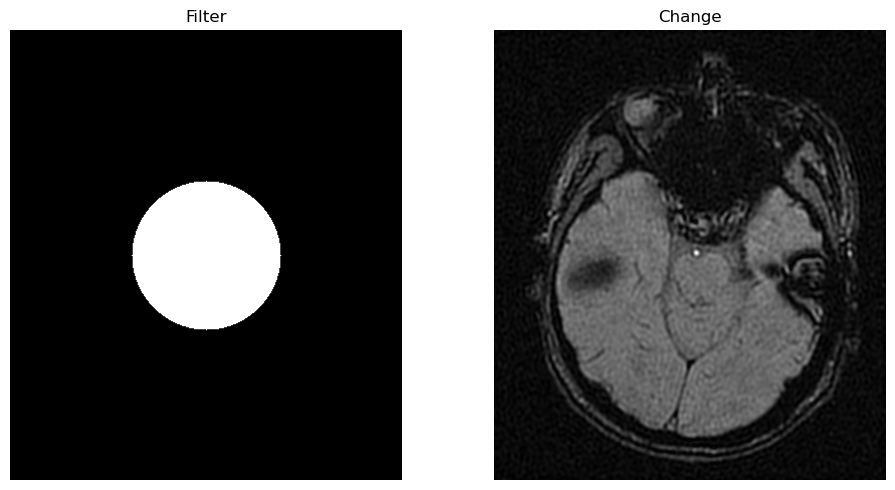

In [7]:
max_distance = ((ds.Rows // 2) ** 2 + (ds.Columns // 2) ** 2) ** 0.5


# 与理想低通滤波器
lowpass_filter_1 = ideal_lowpass_filter(shape, max_distance//4)
# 直接相乘做滤波
lowpass_filtered_img_1 = lowpass_filter_1 * fft_img
# 将结果移回原位置
shifted_back_fft_1 = np.fft.ifftshift(lowpass_filtered_img_1)
# 计算逆傅里叶变换
ideal_lowpass_filtered_img = np.fft.ifft2(shifted_back_fft_1)

# 提取幅度
ideal_lowpass_filtered_img = np.abs(ideal_lowpass_filtered_img)
display(lowpass_filter_1, ideal_lowpass_filtered_img)

可以看到，经过理想低通滤波之后的图像相比加噪图像来说，噪声减少了很多，但是相应的，由于在频域加窗，空间域相当于卷积sinc函数，处理后图像的边界出现了明显的吉布斯效应（振铃）

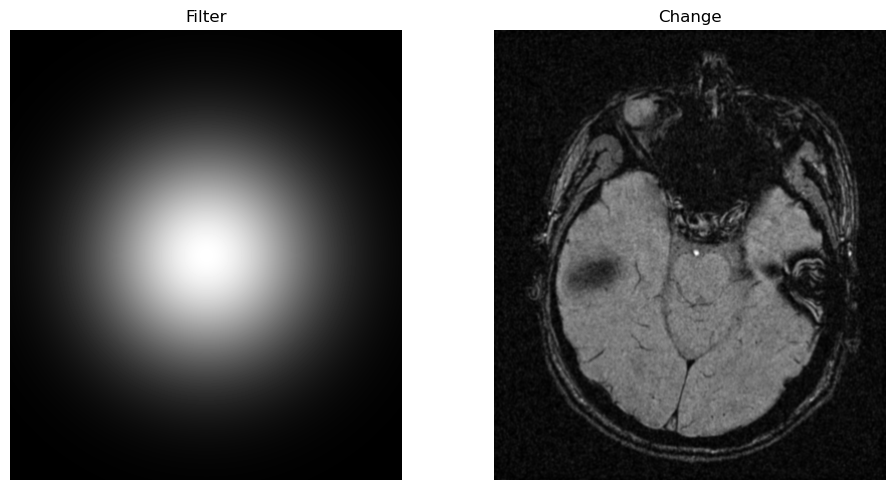

In [8]:
# 与高斯低通滤波器
lowpass_filter_2 = gaussian_lowpass_filter(shape, max_distance//4)
# 直接相乘做滤波
lowpass_filtered_img_2 = lowpass_filter_2 * fft_img
# 将结果移回原位置
shifted_back_fft_2 = np.fft.ifftshift(lowpass_filtered_img_2)
# 计算逆傅里叶变换
gaussian_lowpass_filtered_img = np.fft.ifft2(shifted_back_fft_2)

# 提取幅度
gaussian_lowpass_filtered_img = np.abs(gaussian_lowpass_filtered_img)
display(lowpass_filter_2, gaussian_lowpass_filtered_img)

相比于理想低通，高斯低通滤波器的结果虽然噪声更多，但是边界处的振铃现象更少，边界也更加明显

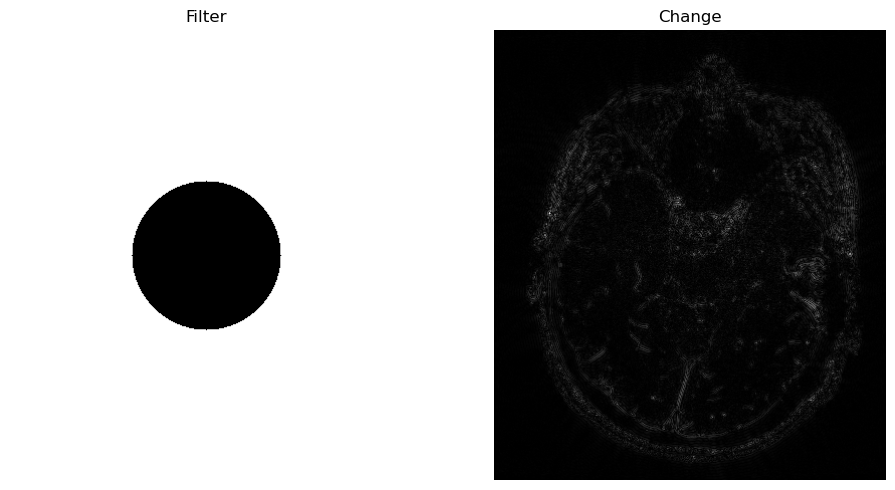

In [9]:
# 与理想高通滤波器
highpass_filter_1 = ideal_highpass_filter(shape, max_distance//4)
# 直接相乘做滤波，注意，这里是用的原图
highpass_filtered_img_1 = highpass_filter_1 * fft_img_ori
# 将结果移回原位置
shifted_back_fft_3 = np.fft.ifftshift(highpass_filtered_img_1)
# 计算逆傅里叶变换
ideal_highpass_filtered_img = np.fft.ifft2(shifted_back_fft_3)

# 提取幅度
ideal_highpass_filtered_img = np.abs(ideal_highpass_filtered_img)
display(highpass_filter_1, ideal_highpass_filtered_img)

这是原图（未加噪声）的理想高通滤波结果，可以发现高频的边界被保留，但是同样的，和理想低通一样，存在很明显的振铃现象  
为什么不处理加噪的？因为这样结果图像的噪声太大了

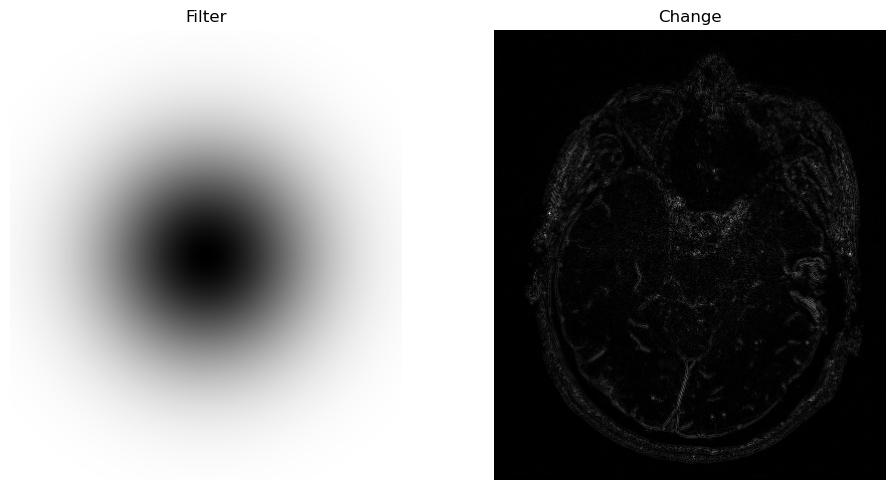

In [10]:
# 与高斯高通滤波器
highpass_filter_2 = gaussian_highpass_filter(shape, max_distance//4)
# 直接相乘做滤波
highpass_filtered_img_2 = highpass_filter_2 * fft_img_ori
# 将结果移回原位置
shifted_back_fft_4 = np.fft.ifftshift(highpass_filtered_img_2)
# 计算逆傅里叶变换
gaussian_highpass_filtered_img = np.fft.ifft2(shifted_back_fft_4)

# 提取幅度
gaussian_highpass_filtered_img = np.abs(gaussian_highpass_filtered_img)
display(highpass_filter_2, gaussian_highpass_filtered_img)

高斯高通滤波器由于振铃现象不明显，在相同的截止频率下反而边界更加清晰

### 2 选择高斯低通滤波器

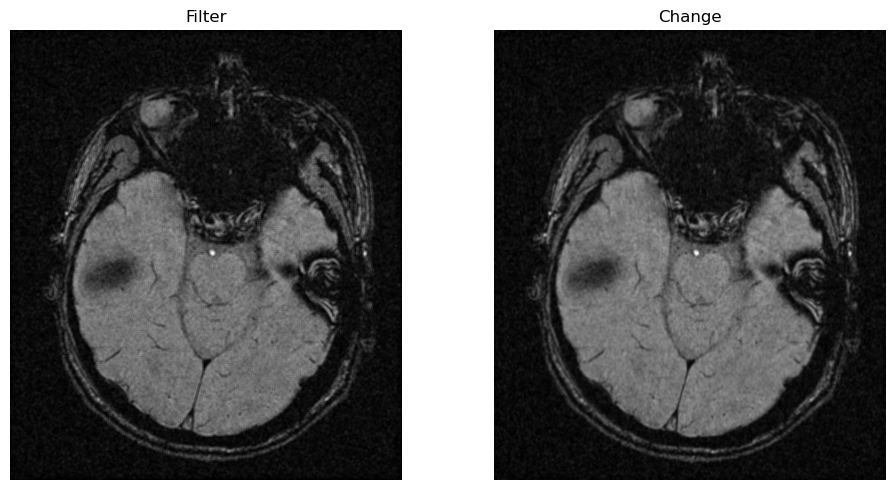

In [11]:
from scipy.signal import convolve2d

# 空间高斯滤波器
space_filter = np.fft.ifftshift(lowpass_filter_2)
space_filter = np.fft.ifft2(space_filter)

# 选择逆变换后的中心3*3作为空间高斯滤波器
space_gaussian_filter = abs(space_filter[ds.Rows//2-1:ds.Rows//2+2, ds.Columns//2-1:ds.Columns//2+2])
space_filtered_img = convolve2d(noisy_image, space_gaussian_filter)

display(space_filtered_img, gaussian_lowpass_filtered_img)

左边是空间滤波的结果，卷积核的大小是$3\times 3$；右边是频域滤波的结果。  
对比两个结果，从降噪的角度来看右边的结果更好；从时间复杂度的角度来说也是频域滤波更低，但是空间复杂度更高。  
这可能是因为单独的$3\times 3$的切片不能完全反应这个滤波器的特性，但是再扩大这个滤波器就会使结果变得过于模糊

### 3 指定的图像复原

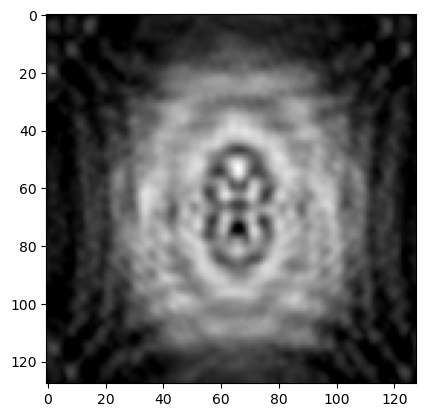

In [12]:
# 读取退化后的图像
data=np.fromfile('degraded_image.dat',dtype='uint16')
data.shape=(128,128,2)
degrade_image=data[:,:,0] + 1j*data[:,:,1]
degrade_image=degrade_image.T
plt.imshow(np.abs(degrade_image), cmap='gray')

fft_degrade_img = np.fft.fft2(degrade_image)
fft_degrade_img = np.fft.fftshift(fft_degrade_img)

通过推向退化的表达式可以得到  
$$G(\mu,\nu) = F(\mu,\nu) \cdot H(\mu,\nu) + N(\mu,\nu)$$  
其中
$$H(\mu,\nu) = \frac{\pi}{\sqrt{\alpha \beta}}e^{-j\left( \frac{\pi^2\mu^2}{\alpha}+\frac{\pi^2\nu^2}{\beta}-\frac{\pi}{2}\right) }$$  
而量化就是对$h(x,y)$做DFT，也就是对$H(\mu,\nu)$进行采样，得到DFT的结果，这里采样使用积分插值

In [18]:
# 退化函数的定义
def H(im, alpha=128, beta=128, s=100):

    rows, cols = im.shape
    H = np.zeros([rows, cols], dtype=complex)
    # 定义网格中心
    crow = int((rows - 1) / 2)
    ccol = int((cols - 1) / 2)
    const = np.pi / np.sqrt(alpha * beta)
    
    # 根据采样率，对每个网格进行采样，采样个数就是采样率
    for u in range(rows):
        for v in range(cols):
            kx, ky = np.meshgrid(np.linspace(u-crow-1, u-crow, s), np.linspace(v-ccol-1, v-ccol, s))
            c = complex(0, -1)
            H[u, v] = sum(sum(const * np.exp(c*((np.pi**2)*(kx**2)/alpha + (np.pi**2)*(ky**2)/beta - np.pi/2))))
    
    return H

fun_H = H(degrade_image)

#### 3.1 逆滤波

In [14]:
# 逆滤波
inver_F = fft_degrade_img / (fun_H + 100)
inver_f = np.fft.ifftshift(inver_F)
inver_f = np.abs(np.fft.ifft2(inver_f))
# plt.imshow(inver_f, cmap='gray')

由于$\max{|H|}\approx 245$，选择一个远小于其值的$K$，作为防止无穷大的噪音出现的手段，这里$K=10$

#### 3.2 维纳滤波

In [15]:
# 维纳滤波
H_wie = np.abs(fun_H) ** 2 / fun_H / (np.abs(fun_H)**2 + 1000)
inver_F2 = fft_degrade_img * H_wie
inver_f2 = np.fft.ifftshift(inver_F2)
inver_f2 = np.abs(np.fft.ifft2(inver_f2))
# plt.imshow(inver_f2, cmap='gray')

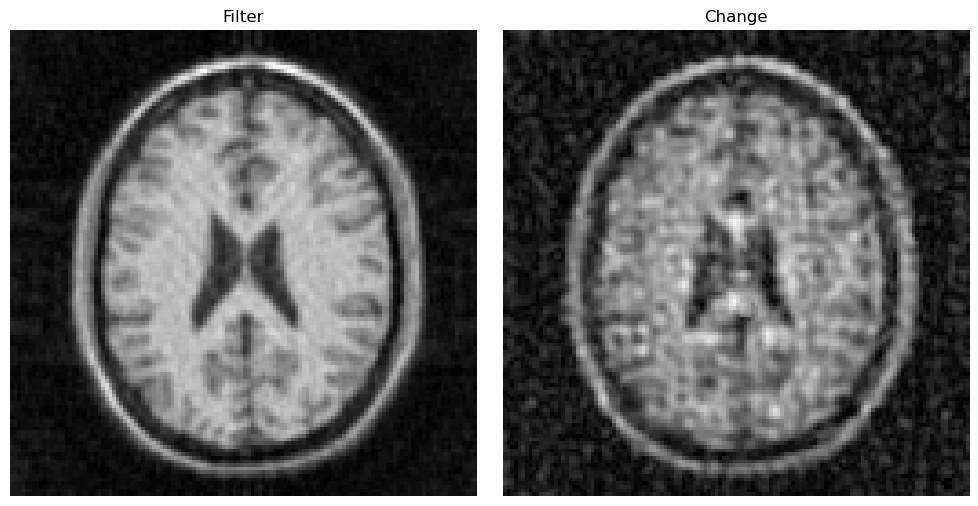

In [16]:
display(inver_f2, inver_f)

左边是维纳滤波的结果，右边是逆滤波的结果，调整$K$的值图像会变化。  
对于逆滤波，在$K<200$左右$K$越大噪音越小，当$K>200$时，图像变得不可名状，如下图，原因是$\max{H}$是要远大于H的其他值的（从做对数变换也能看出），故当$K$接近最大值时，整个图像的各个频率分量都很小，导致了图像变得异常  
而对于维纳滤波，$K$越大，图像的噪音越少，相应的，图像也变得更加模糊（平滑），这是可以预见的，因为维纳滤波的自适应能力更好，而加大$K$相当于减弱高频成分  
从结果上来看，维纳滤波的去噪能力和复原能力都强于逆滤波，毕竟算法更复杂  
但是两者的噪声过滤都不太行，逆滤波是本来就不行，维纳滤波是因为没有噪声的功率谱，只能用常数进行估计，因此一|定存在一个常数使得噪声最小，但是我不想找了  


In [17]:
# 逆滤波
inver_F = fft_degrade_img / (fun_H + 200)
inver_f = np.fft.ifftshift(inver_F)
inver_f = np.abs(np.fft.ifft2(inver_f))
# plt.imshow(inver_f, cmap='gray')
# 你真的要看吗，那就去掉注释